# Assignment #2

# In This assignment you are asked to read a data which include 48505 articles (Documents). Then fint the most similar documents using Locality Sensitive Hashing. Follow the lecture covering this topic step by step.

## 1. Data is available in Json format and you need to read it. 'https://www.ux.uis.no/~vsetty/data/assignment2_aricles.json' (5 points)
## 2. Shingle the documents (10 points)
### Tips:
* Use string package to cleanup the articles e.g, str.maketrans('', '', string.
punctuation)
* It is better to convert text to lower case that way you get fewer n-grams
* apply ngrams(x.split(), n) using ngrams from nltk on the content + title for computing n-grams, for this data n = 2 is suffcient
  * You can use n-gram at word level for this task
  * try with different n-gram values 
  * You can use ngrams from nltk for this

## 3. Convert n-grams into binary vector representation for each document. You can do some optimzations if the matrix is too big. (10 points)
* For example,

  * Select top 10000 most frequent n-grams.
  * You may also try smaller values of n (like 2 or 3) which result in fewer n-grams.
  * Finally, you can also try sparse matrix representation. Like csr_matrix from scipy.sparse. It works even with full vocabulary.
    * Given a list of n-grams for each document, see how to builid a sparse matrix here https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html

## 4. We need hash function that maps integers 0, 1, . . . , k − 1 to bucket numbers 0 through k − 1. It might be impossible to avoid collisions but as long as the collions are too many it won't matter much. (10 points)
* The simplest would be using the builtin hash() function, it can be for example, hash(rownumber) % Numberofbuckets
* You can generate several of these hash functions by xoring a random integer (hash(rownumber)^randint) % Numberofbuckets
* It can also be a as simple as (rownumber * randint) % Numberofbuckets

## 5. Compute minhash following the faster algorithm from the lecture (10 points)
## 6. Hash signature bands into buckets. Find a way to combine all the  signature values in a band and hash them into a number of buckets ususally very high. (10 points)
* Easiest way is to add all the signature values in the bucket and use a similar hash function like before
* You should use the same hash function for all bands. And all documents ending up in same bucket for at least one band are considered as candidate pairs.

## 7. Tune parameters to make sure the threshold is appropriate. (10 points)
* plot the probability of two similar items falling in same bucket for different threshold values

## 8. Choose the best parameters and get nearest neighbors of each articles (20 points)
* Jaccard Similarity
* convert hash table into dictionary of article ids and its other articles that hashed in at least 1 same bucket

## 9. Write the nearest neibhors of each document to submissions.csv (comma separated, first column is the current document followed by a list of nearest neighbors) file and get the score (10 points)

## 10. Write a report + notebook + submission file in a zip file (5 points)

In [29]:
'''Import packages'''
import pandas as pd
import numpy as np
import json
import string 
from nltk import ngrams
import nltk
from collections import Counter
from random import shuffle
from scipy import sparse 
import re
import numpy as np
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fisay\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# 1

In [30]:
# Open the file
with open('spice.json') as f:
    # Load the data from the file
    articles = json.load(f)
np.shape(articles)

(48505,)

In [31]:
test_articles=articles[0:100] #Test for a sample of load 100 articles.
# more articles can be loaded to test the full code e.g : 48505 

# 2

In [32]:
def getFrequentNgrams(articles, shingle_size=2,n_freq=1000):
    # Define a regular expression pattern to match special characters
    pattern = re.compile('[^\w\s]')
    
    # Create a list of lists of shingles
    shingled_articles = []
    for article in articles:
        # Concatenate the title and content values and remove special characters
        text = article['Title'] + ' ' + article['Content']
        text = re.sub(pattern, '', text)
        
        # Split the text into a list of words and create a list of shingles
        words = text.split()
        
        shingles = nltk.ngrams(words, shingle_size)
        counter = Counter(shingles)
    
        most_common = counter.most_common(n_freq)
        shingled_articles.append(most_common)
    return shingled_articles


In [33]:
test=getFrequentNgrams(test_articles,2)

# 3

In [34]:
def getBinaryMatrix(ngram_list):
    """
    Convert a list of n-gram lists to a binary matrix.
    Each row of the binary matrix corresponds to a document,
    and each column corresponds to an n-gram. The (i, j)-th
    element of the matrix is 1 if the j-th n-gram appears in
    the i-th document, and 0 otherwise.
    """
    # Get the set of all n-grams across all documents
    all_ngrams = set(ngram for ngram_list in ngram_list for ngram, freq in ngram_list)

    # Create a dictionary that maps each n-gram to an index
    ngram_index = {ngram: i for i, ngram in enumerate(sorted(all_ngrams))}

    # Initialize a matrix to hold the binary vectors for each document
    num_documents = len(ngram_list)
    num_ngrams = len(all_ngrams)
    binary_matrix = np.zeros((num_documents, num_ngrams), dtype=int)

    # Convert each document's n-gram list to a binary vector
    for i, ngram_list in enumerate(ngram_list):
        for ngram, freq in ngram_list:
            j = ngram_index[ngram]
            binary_matrix[i, j] = 1

    return binary_matrix



In [35]:
sparse_mat=getBinaryMatrix(test)


In [36]:
len(sparse_mat[2])

29880

# 4

In [37]:
def create_hash_func(sparse_vec):
    # function for creating the hash vector/function
    hash_ex = list(range(1, len(sparse_vec)+1))
    shuffle(hash_ex)
    return hash_ex

def build_minhash_func(sparse_vec, nbits: int):
    # function for building multiple minhash vectors
    hashes = []
    for _ in range(nbits):
        hashes.append(create_hash_func(sparse_vec))
    return hashes





In [38]:
# we create 100 minhash vectors
minhash_func = build_minhash_func(sparse_mat[0], 100)


# 5

In [39]:

def create_signature(vector, hash_functions):
    # Create a signature for a binary vector using a list of hash functions
    signature = []
    for func in hash_functions:
        for i in range(1, len(vector) + 1):
            idx = func.index(i)
            signature_val = vector[idx]
            if signature_val == 1:
                signature.append(i)
                break
    return signature

def getMinHashSignatureMatrix(binary_matrix, hash_functions):
    # Create a signature matrix for a binary matrix using a list of hash functions
    signature_matrix = []
    for vector in binary_matrix:
        signature_vector = create_signature(vector, hash_functions)
        signature_matrix.append(signature_vector)
    return signature_matrix

In [40]:
def create_signature_2(sparse_matrix, hash_function_matrix):
    num_hashes = np.shape(hash_function_matrix)[0]
    num_cols = np.shape(sparse_matrix)[0]
    # Initialize the signature matrix with infinity values

    signatures = np.full((num_hashes, num_cols), np.inf)

    # Iterate over each hash function
    for i in range(num_hashes):
        # Compute the dot product of the sparse matrix with the i-th hash function
        dot_product =np.array( sparse_matrix*hash_function_matrix[i])
        # Update the signature matrix with the minimum value of the dot product
        #signatures[i] = np.minimum(signatures[i], dot_product[i])
        signatures[i]=np.where(dot_product>0, dot_product, np.inf).min(axis=1)
    
    return signatures

In [41]:
signature_matrix2=create_signature_2(sparse_mat,minhash_func)

In [42]:
#signature_matrix=getMinHashSignatureMatrix(sparse_mat,minhash_func)

In [43]:
signature_matrix2

array([[   5.,   98.,   92., ...,  489.,  177.,  507.],
       [ 438.,   50.,  301., ...,  172.,   83.,  435.],
       [  90.,  132.,  771., ...,   57.,   38.,  371.],
       ...,
       [   2.,  222.,  338., ...,   49.,   33.,  103.],
       [ 411.,   89.,   53., ..., 1191.,  377.,  530.],
       [ 103.,   25.,  152., ...,  144.,  201.,  527.]])

# 6

In [44]:
def split_subvector_tobands(signature, no_b):

    assert len(signature) % no_b == 0
    r = int(len(signature) / no_b)
    # code splitting signature in b parts
    subvecs = []
    for i in range(0, len(signature), r):
        subvecs.append(signature[i : i+r])
    return subvecs

In [45]:
def LSH(signature_matrix2, no_b ):
    band_matrix=[]
    for signature in signature_matrix2:
        signature_band=split_subvector_tobands(signature, no_b)
        band_matrix.append(np.array(signature_band))

    Lsh=dict()
    i=0
    
    for article_considered in band_matrix:
        for article_checked in band_matrix:
            for ij, matrix in enumerate(band_matrix):
                if np.array_equal(matrix, article_checked):
                    global index          
                    index = ij
                    break
            if i==index :
                continue
            else:
                for article_considered_row, article_checked_row in zip(article_considered, article_checked):
                    if (article_considered_row == article_checked_row).all():
                    
                        if i in Lsh:
                            Lsh[i].append(index)

                        else:
                            Lsh[i] = [index]

        i=i+1
    return(Lsh,band_matrix)



Your treshold is 100%, and your r=signature/bands

In [46]:
lsh=LSH(signature_matrix2, 50)

In [47]:
Similar_articles=lsh[0]

In [48]:
lsh[0]

{1: [27],
 9: [38],
 11: [15],
 15: [11, 64],
 27: [1],
 29: [60, 84],
 38: [9],
 52: [76],
 58: [96],
 60: [29],
 61: [84],
 64: [15],
 76: [52],
 84: [29, 61],
 96: [58]}

# 7

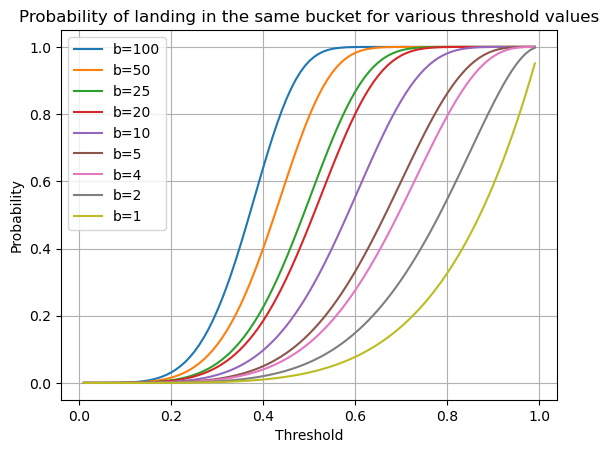

In [49]:
import matplotlib.pyplot as plt

def probability(jad_sim, row, band):
    # jad_sim: similarity
    # row: rows (per band)
    # band: number of bands
    return 1 - (1 - jad_sim**row)**band

def plotFunction(row=5, b_values=[100, 50, 25, 20, 10, 5, 4, 2, 1]):
    plt.figure()
    for b in b_values:
        P_list = []  # Create an empty list to store all the P values
        for jad_sim in np.arange(0.01, 1, 0.01):
            P = probability(jad_sim, row, b)
            P_list.append(P)  # Append the P value to the list
        plt.plot(np.arange(0.01, 1, 0.01), P_list, label='b={}'.format(b))  # Plot the list of P values
    plt.xlabel('Threshold')
    plt.ylabel('Probability')
    plt.title('Probability of landing in the same bucket for various threshold values')
    plt.grid()
    plt.legend()
    plt.show()

plotFunction()

The code below does the same thing but puts rows into consideration

C:\Users\fisay\AppData\Local\Temp\ipykernel_13924\681100041.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
C:\Users\fisay\AppData\Local\Temp\ipykernel_13924\681100041.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
C:\Users\fisay\AppData\Local\Temp\ipykernel_13924\681100041.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
C:\Users\fisay\AppData\Local\Temp\ipykernel_13924\681100041.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({
C:\Users\fisay\AppData\Local\Temp\ipykernel_13924\681100041.py:17: FutureWarning: Th

<AxesSubplot:xlabel='s', ylabel='P'>

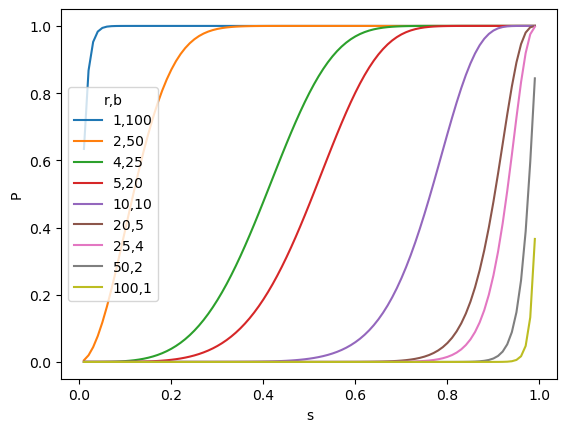

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

results = pd.DataFrame({
    's': [],
    'P': [],
    'r,b': []
})

for s in np.arange(0.01, 1, 0.01):
    total = 100
    for b in [100, 50, 25, 20, 10, 5, 4, 2, 1]:
        r = int(total/b)
        P = probability(s, r, b)
        results = results.append({
            's': s,
            'P': P,
            'r,b': f"{r},{b}"
        }, ignore_index=True)

def probability(jad_sim, row, band):
    # jad_sim: similarity
    # row: rows (per band)
    # band: number of bands
    return 1 - (1 - jad_sim**row)**band

sns.lineplot(data=results, x='s', y='P', hue='r,b')

# reference :https://github.com/pinecone-io/examples/blob/master/locality_sensitive_hashing_traditional/sparse_implementation.ipynb.

# 8

In [51]:
def getJaccardSimilarityScore(a, b):
    return len(set(a).intersection(set(b))) / len(set(a).union(set(b)))

def jaccard_for_lsh(dictionary_store):
    dictionary={}
    for article_referenced,articles_connected in dictionary_store.items():
        for article_con in articles_connected:
            jaccard=getJaccardSimilarityScore(signature_matrix2[article_referenced],signature_matrix2[article_con])# hardcoding here 
            if article_referenced in dictionary:
                dictionary[article_referenced].append(jaccard)
            else:
                dictionary[article_referenced] = [jaccard]
    return(dictionary)


In [52]:
jaccard_file=jaccard_for_lsh(Similar_articles)

In [53]:
jaccard_file

{1: [0.25161290322580643],
 9: [0.2222222222222222],
 11: [0.22875816993464052],
 15: [0.22875816993464052, 0.2702702702702703],
 27: [0.25161290322580643],
 29: [0.20945945945945946, 0.2536231884057971],
 38: [0.2222222222222222],
 52: [0.2866666666666667],
 58: [0.17834394904458598],
 60: [0.20945945945945946],
 61: [0.26573426573426573],
 64: [0.2702702702702703],
 76: [0.2866666666666667],
 84: [0.2536231884057971, 0.26573426573426573],
 96: [0.17834394904458598]}

Generally, a Jaccard similarity score above 0.8 or 0.9 may be considered high and may warrant further investigation. However, it is ultimately up to the judgement of the user to determine what score is considered significant in their specific context.

In [54]:
p=pd.Series(jaccard_file)
q=pd.Series(Similar_articles)

In [55]:
db=pd.concat([q,p], axis=1)
db = db.rename(columns={0: 'NN Article Id', 1: 'Jaccard similarity'})
db

,NN Article Id,Jaccard similarity
1,[27],[0.25161290322580643]
9,[38],[0.2222222222222222]
11,[15],[0.22875816993464052]
15,"[11, 64]","[0.22875816993464052, 0.2702702702702703]"
27,[1],[0.25161290322580643]
29,"[60, 84]","[0.20945945945945946, 0.2536231884057971]"
38,[9],[0.2222222222222222]
52,[76],[0.2866666666666667]
58,[96],[0.17834394904458598]
60,[29],[0.20945945945945946]


# 9

In [56]:
db.to_csv('submission.csv')